# Pseudolikelihood Maximisation (PLM)

In [2]:
from sympy import symbols, Sum, IndexedBase, log, cosh, diff, Piecewise, Ne, simplify
import sympy as sp

In [3]:
# Define the symbols for the dimensions and indices
n, d = symbols('n d', integer=True)
i, j, k = symbols('i j k', integer=True)

# Define the symbolic indexed bases for J, h, and X
J = IndexedBase('J', shape=(d, d))
h = IndexedBase('h', shape=(d,))
X = IndexedBase('X', shape=(n, d))

# Define S_ij excluding the k = j term
S_ij = Sum(Piecewise((J[j, k] * X[i, k], Ne(k, j)), (0, True)), (k, 1, d)) + h[j]

# Define the log-pseudolikelihood function LL
LL = Sum(X[i, j] * S_ij - log(2 * cosh(S_ij)), (i, 1, n), (j, 1, d))
LL

Sum(Piecewise(((h[j] + Sum(J[j, k]*X[i, k], (k, 1, d)))*X[i, j] - log(2*cosh(h[j] + Sum(J[j, k]*X[i, k], (k, 1, d)))), Ne(j, k)), ((h[j] + Sum(0, (k, 1, d)))*X[i, j] - log(2*cosh(h[j] + Sum(0, (k, 1, d)))), True)), (i, 1, n), (j, 1, d))

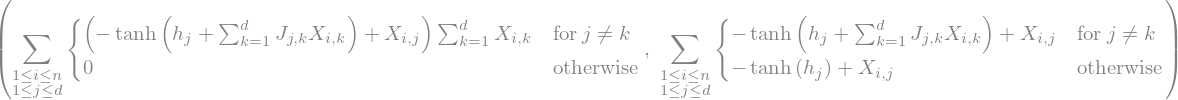

In [4]:
# Compute the symbolic gradients
grad_J_jk = diff(LL, J[j, k])
grad_h_j = diff(LL, h[j])

# Simplify the gradients
grad_J_jk_simplified = simplify(grad_J_jk)
grad_h_j_simplified = simplify(grad_h_j)

# Initialise pretty-printing
sp.init_printing(use_unicode=True)

# Display the expressions
grad_J_jk_simplified, grad_h_j_simplified

In [6]:
import numpy as np
import pandas as pd
from Utility.decorators import timer

@timer
def log_pseudolikelihood_and_gradients_v1(J, h, X):
    """
    Initial code for calculating the log-pseudolikelihood and gradients closely follows my derived expression.
    """
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J = np.zeros_like(J)  # Initialise the gradient of J
    grad_h = np.zeros_like(h)  # Initialise the gradient of h

    for i in range(n):
        for j in range(d):
            # Compute S_ij without the contribution from jth term
            S_without_j = np.dot(J[j, :], X[i, :]) - J[j, j] * X[i, j]
            S_ij = S_without_j + h[j]
            
            # Update log-likelihood
            log_likelihood += X[i, j] * S_ij - np.log(2 * np.cosh(S_ij))
            
            # Update gradient of h
            grad_h[j] += -np.tanh(S_ij) + X[i, j]
            
            # Update gradient of J
            for k in range(d):
                if k != j:
                    grad_J[j, k] += (-np.tanh(S_ij) + X[i, j]) * X[i, k]
                    grad_J[k, j] = grad_J[j, k]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v2(J, h, X):
    """
    Streamlined code for calculating the log-pseudolikelihood and gradients.
    """
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood, grad_J, grad_h = 0, np.zeros_like(J), np.zeros_like(h)

    for i in range(n):
        for j in range(d):
            x_ij = X[i, j]
            S_ij = np.dot(J[j, :], X[i, :]) - J[j, j] * x_ij + h[j]
            log_likelihood += x_ij * S_ij - np.log(2 * np.cosh(S_ij))
            tanh_S_ij = np.tanh(S_ij)
            grad_h[j] += -tanh_S_ij + x_ij
            mask = np.ones(d, dtype=bool)
            mask[j] = False
            grad_J[j, mask] += (-tanh_S_ij + x_ij) * X[i, mask]
            grad_J[mask, j] = grad_J[j, mask]

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v3(J, h, X):
    """
    Vectorised code for super speedy performance.
    """
    d = X.shape[1]  # Number of dimensions
    log_likelihood, grad_J, grad_h = 0, np.zeros_like(J), np.zeros_like(h)

    # Vectorised version
    J_diag = np.diag(J)  # Get the diagonal of J
    S_ij = X @ J - X * J_diag + h  # Compute S_ij vectorized, broadcasting h
    log_likelihood = (X * S_ij).sum() - np.sum(np.log(2 * np.cosh(S_ij)))

    tanh_S_ij = np.tanh(S_ij)
    grad_h = np.sum(X - tanh_S_ij, axis=0)

    # Compute the gradient for J, excluding the diagonal
    # Create a mask to zero out diagonal contributions in the grad_J calculation
    mask = np.ones_like(J) - np.eye(d)
    grad_J = ((X - tanh_S_ij).T @ X) * mask
    grad_J = (grad_J + grad_J.T)

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

# Define test inputs
X = pd.read_csv('Results/data_matrix.csv').drop(columns=["Date"]).to_numpy()
n, d = X.shape

# Initialise J as a symmetric matrix with zeros on the diagonal
# Elements are drawn from a uniform distribution over [-1, 1]
J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)  # Upper triangular part with 1 offset to exclude diagonal
J = J_upper + J_upper.T  # Symmetric matrix with zeros on the diagonal

# Initialise h as a one-dimensional array (vector) of size d
# Elements are drawn from a uniform distribution over [-1, 1]
h = np.random.uniform(-1, 1, size=d)

def compare_pseudolikelihood_functions(J, h, X):
    # Function names in a dictionary for iteration
    functions = {
        'v1': log_pseudolikelihood_and_gradients_v1,
        'v2': log_pseudolikelihood_and_gradients_v2,
        'v3': log_pseudolikelihood_and_gradients_v3
    }

    # Run each function and store results
    results = {name: func(J, h, X) for name, func in functions.items()}

    # Print results for each function
    for name, result in results.items():
        print(f"\nFunction {name} Results:")
        print("-log_likelihood:", result[0])
        print("-grad_J:\n", result[1][:3, :3])  # Print a 3x3 submatrix
        print(f"-grad_h:{result[2][:3]}")  # Print first 3 elements

    # Define specific pairs to compare
    comparison_pairs = [('v1', 'v2'), ('v1', 'v3')]

    # Compare results between each specified pair of functions
    for name1, name2 in comparison_pairs:
        result1, result2 = results[name1], results[name2]
        ll_same = np.allclose(result1[0], result2[0])
        grad_J_same = np.allclose(result1[1], result2[1])
        grad_h_same = np.allclose(result1[2], result2[2])
        print(f"{name1} vs {name2}: "
              f"LL: {'Same' if ll_same else 'Different'}, "
              f"Grad_J: {'Same' if grad_J_same else 'Different'}, "
              f"Grad_h: {'Same' if grad_h_same else 'Different'}")

compare_pseudolikelihood_functions(J, h, X)


'log_pseudolikelihood_and_gradients_v1' execution time: 3.231254 seconds
'log_pseudolikelihood_and_gradients_v2' execution time: 1.024625 seconds
'log_pseudolikelihood_and_gradients_v3' execution time: 0.009076 seconds

Function v1 Results:
-log_likelihood: 285183.9474639205
-grad_J:
 [[   -0.          -651.24048659  -896.31130442]
 [ -651.24048659    -0.         -3527.76826775]
 [ -896.31130442 -3527.76826775    -0.        ]]
-grad_h:[-766.74183655 -615.12186606  336.64328773]

Function v2 Results:
-log_likelihood: 285183.9474639205
-grad_J:
 [[   -0.          -651.24048659  -896.31130442]
 [ -651.24048659    -0.         -3527.76826775]
 [ -896.31130442 -3527.76826775    -0.        ]]
-grad_h:[-766.74183655 -615.12186606  336.64328773]

Function v3 Results:
-log_likelihood: 285183.94746391964
-grad_J:
 [[   -0.          -651.24048659  -896.31130442]
 [ -651.24048659    -0.         -3527.76826775]
 [ -896.31130442 -3527.76826775    -0.        ]]
-grad_h:[-766.74183655 -615.12186606  33

# Optimisation

In [7]:
from Utility.IsingOptimiser import IsingOptimiser

ising_optimiser = IsingOptimiser('Results/data_matrix.csv')
J_optimised, h_optimised = ising_optimiser.optimise_all_subsets()
ising_optimiser.save_results(J_optimised, h_optimised, J_file_path='Results/J_matrix.csv', h_file_path='Results/h_vector.csv')

subset_1: Currencies 0 to 6
subset_2: Currencies 7 to 13
subset_3: Currencies 14 to 19
subset_4: Currencies 20 to 25
Optimising initial subsets...

Optimisation successful for subset 1: True
'wrapper' execution time: 0.015326 seconds
Subset subset_1 optimised.

Optimisation successful for subset 2: True
'wrapper' execution time: 0.014523 seconds
Subset subset_2 optimised.

Optimisation successful for subset 3: True
'wrapper' execution time: 0.010313 seconds
Subset subset_3 optimised.

Optimisation successful for subset 4: True
'wrapper' execution time: 0.008599 seconds
Subset subset_4 optimised.

Combining into larger subsets for further optimisation...

Optimisation successful for subset 1_2: True
'wrapper' execution time: 0.264385 seconds
Optimisation successful for subset 3_4: True
'wrapper' execution time: 0.099342 seconds
Larger subsets optimised.

Performing final optimisation with the entire dataset...

Optimisation successful for subset full: True
'wrapper' execution time: 0.79

# Boltzmann Machine

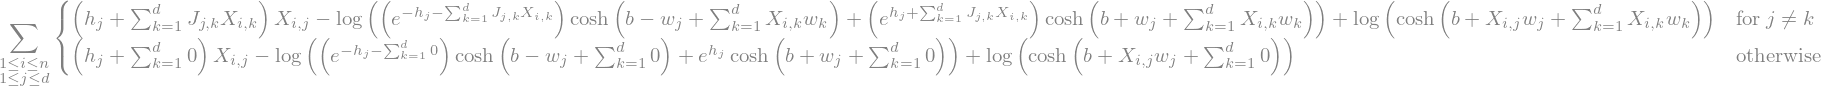

In [8]:
from sympy import symbols, Sum, IndexedBase, log, cosh, exp, diff, Piecewise, Ne, simplify
import sympy as sp

# Define the symbols for the dimensions and indices
n, d = symbols('n d', integer=True)
i, j, k = symbols('i j k', integer=True)
b = symbols('b', real=True)

# Define the symbolic indexed bases for J, h, w, and X
J = IndexedBase('J', shape=(d, d))
h = IndexedBase('h', shape=(d,))
w = IndexedBase('w', shape=(d,))
X = IndexedBase('X', shape=(n, d))

# Define S_ij and S_ik excluding the k = j term
S_ij = Sum(Piecewise((J[j, k] * X[i, k], Ne(k, j)), (0, True)), (k, 1, d)) + h[j]
S_ik = Sum(Piecewise((w[k] * X[i, k], Ne(k, j)), (0, True)), (k, 1, d)) + b

# Define the log-pseudolikelihood function LL
LL = Sum(X[i, j] * S_ij + log(cosh(w[j] * X[i, j] + S_ik)) - log(
    exp(S_ij) * cosh(w[j] + S_ik) + exp(-S_ij) * cosh(-w[j] + S_ik)), (i, 1, n), (j, 1, d))
LL

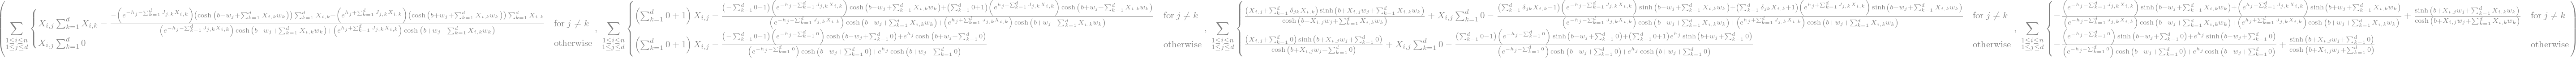

In [9]:
# Compute the symbolic gradients
grad_J_jk = diff(LL, J[j, k])
grad_h_j = diff(LL, h[j])
grad_w_j = diff(LL, w[j])
grad_b = diff(LL, b)

# Simplify the gradients
grad_J_jk_simplified = simplify(grad_J_jk)
grad_h_j_simplified = simplify(grad_h_j)
grad_w_j_simplified = simplify(grad_w_j)
grad_b_simplified = simplify(grad_b)

# Initialise pretty-printing
sp.init_printing(use_unicode=True)

# Display the expressions
grad_J_jk, grad_h_j, grad_w_j, grad_b

In [7]:
import numpy as np
import pandas as pd
from Utility.decorators import timer

@timer
def log_pseudolikelihood_v1(J, h, w, b, X):
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J = np.zeros_like(J)  # Initialise the gradient of J
    grad_h = np.zeros_like(h)  # Initialise the gradient of h
    grad_w = np.zeros_like(w)  # Initialise the gradient of w
    grad_b = 0                 # Initialise the gradient of b as a scalar

    for i in range(n):
        for j in range(d):
            # Compute S_ij without the contribution from the j-th term
            S_without_j = np.dot(J[j, :], X[i, :]) - J[j, j] * X[i, j]
            S_ij = S_without_j + h[j]
            
            # Compute S_ik
            S_ik = np.dot(w, X[i, :]) + b - w[j] * X[i, j]

            # components used in the log likelihood and gradients
            x_ij = X[i, j]
            exp_pos_Sij = np.exp(S_ij)
            exp_neg_Sij = np.exp(-S_ij)
            cosh_pos = np.cosh(w[j] + S_ik)
            cosh_neg = np.cosh(w[j] - S_ik)
            sinh_pos = np.sinh(w[j] + S_ik)
            sinh_neg = np.sinh(w[j] - S_ik)
            denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

            # Update log-likelihood for the new LL expression
            log_likelihood += (
                x_ij * S_ij +
                np.log(np.cosh(w[j] * X[i, j] + S_ik)) -
                np.log(denominator)
            )

            # grad_h update
            numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            grad_h[j] += x_ij - (numerator_h / denominator)

            # grad_w update
            numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_w[j] += x_ij * (np.tanh(w[j] * X[i, j] + S_ik) - (numerator_w / denominator))

            # grad_b update
            numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_b += np.tanh(w[j] * X[i, j] + S_ik) - (numerator_b / denominator)

            # grad_J update
            numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            for k in range(d):
                if k != j:
                    grad_J[j, k] += (x_ij - (numerator_J / denominator)) * X[i, k]
                    grad_J[k, j] = grad_J[j, k]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

@timer
def log_pseudolikelihood_v2(J, h, w, b, X):
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J, grad_h, grad_w, grad_b = np.zeros_like(J), np.zeros_like(h), np.zeros_like(w), 0

    for i in range(n):
        full_S_ik = np.dot(w, X[i, :]) + b
        for j in range(d):
            x_ij = X[i, j]
            S_ij = np.dot(J[j, :], X[i, :]) - J[j, j] * X[i, j] + h[j]
            S_ik = np.dot(w, X[i, :]) - w[j] * X[i, j] + b

            exp_pos_Sij = np.exp(S_ij)
            exp_neg_Sij = np.exp(-S_ij)
            cosh_pos = np.cosh(w[j] + S_ik)
            cosh_neg = np.cosh(w[j] - S_ik)
            sinh_pos = np.sinh(w[j] + S_ik)
            sinh_neg = np.sinh(w[j] - S_ik)
            denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

            # Update log-likelihood for the new LL expression
            log_likelihood += (
                x_ij * S_ij +
                np.log(np.cosh(full_S_ik)) -
                np.log(denominator)
            )

            # grad_h update
            numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            grad_h[j] += x_ij - (numerator_h / denominator)

            # grad_w update
            numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_w[j] += x_ij * (np.tanh(full_S_ik) - (numerator_w / denominator))

            # grad_b update
            numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_b += np.tanh(full_S_ik) - (numerator_b / denominator)

            # grad_J update
            mask = np.ones(d, dtype=bool)
            mask[j] = False
            numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            grad_J[j, mask] += (x_ij - (numerator_J / denominator)) * X[i, mask]
            grad_J[mask, j] = grad_J[j, mask]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

@timer
def log_pseudolikelihood_v3(J, h, w, b, X):
    d = X.shape[1]  # Number of dimensions

    S_ij = X @ J - X * np.diag(J)+ h  # Broadcasting h and subtracting k=j terms
    full_S_ik = X @ w + b # for all samples
    S_ik = X @ w.reshape(-1, 1) + b - X * w  # Broadcasting w

    # Calculate the components used in the log likelihood and gradients
    exp_pos_Sij = np.exp(S_ij)
    exp_neg_Sij = 1 / exp_pos_Sij
    cosh_pos = np.cosh(w + S_ik)
    cosh_neg = np.cosh(w - S_ik)
    sinh_pos = np.sinh(w + S_ik)
    sinh_neg = np.sinh(w - S_ik)
    denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

    x_times_Sij = X * S_ij  # Sum over dimensions for each sample
    log_numerator= np.log(np.cosh(full_S_ik.reshape(-1, 1)))  # Reshape to 2D
    log_denominator = np.log(denominator)  # Sum over dimensions for each sample

    # Combine the terms and sum over all samples to get the scalar log-likelihood
    log_likelihood = (x_times_Sij + log_numerator - log_denominator).sum()

    # Gradients
    numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
    grad_h = (X - numerator_h / denominator).sum(axis=0)

    numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
    grad_w = (X.T * (np.tanh(full_S_ik.T) - (numerator_w / denominator).T)).sum(axis=1)

    numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
    grad_b = (np.tanh(full_S_ik.reshape(-1, 1)) - (numerator_b / denominator)).sum(axis=0).sum()

    # Gradient for J, excluding the diagonal
    mask = np.ones_like(J) - np.eye(d)
    numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
    grad_J = ((X - numerator_J / denominator).T @ X) * mask
    grad_J = grad_J + grad_J.T  # Symmetrise

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

# Read data
X = pd.read_csv('Results/data_matrix.csv').drop(columns=["Date"]).to_numpy()
n, d = X.shape

# Initialise J, h, w, and b
J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)
J = J_upper + J_upper.T
h = np.random.uniform(-1, 1, size=d)
w = np.random.uniform(-1, 1, size=d)
b = np.random.uniform(-1, 1)

# Function to compare pseudolikelihood functions
def compare_pseudolikelihood_functions(J, h, w, b, X):
    functions = {
        'v1': log_pseudolikelihood_v1,
        'v2': log_pseudolikelihood_v2,
        'v3': log_pseudolikelihood_v3
    }

    results = {name: func(J, h, w, b, X) for name, func in functions.items()}

    for name, result in results.items():
        if result[0] is not None:  # Check if result is not None
            print(f"\nFunction {name} Results:")
            print("-log_likelihood:", result[0])
            print("-grad_J:\n", result[1][:3, :3])
            print(f"-grad_h:{result[2][:3]}")
            print(f"-grad_w:{result[3][:3]}")
            print(f"-grad_b:{result[4]}")

    comparison_pairs = [('v1', 'v2'), ('v1', 'v3')]

    # Compare results between each specified pair of functions
    for name1, name2 in comparison_pairs:
        result1, result2 = results[name1], results[name2]
        ll_same = np.allclose(result1[0], result2[0])
        grad_J_same = np.allclose(result1[1], result2[1])
        grad_h_same = np.allclose(result1[2], result2[2])
        grad_w_same = np.allclose(result1[3], result2[3])
        grad_b_same = np.allclose(result1[4], result2[4])
        print(f"{name1} vs {name2}: "
              f"LL: {'Same' if ll_same else 'Different'}, "
              f"Grad_J: {'Same' if grad_J_same else 'Different'}, "
              f"Grad_h: {'Same' if grad_h_same else 'Different'}, "
              f"Grad_w: {'Same' if grad_w_same else 'Different'}, "
              f"Grad_b: {'Same' if grad_b_same else 'Different'}")

compare_pseudolikelihood_functions(J, h, w, b, X)


'log_pseudolikelihood_v1' execution time: 2.661882 seconds
'log_pseudolikelihood_v2' execution time: 1.683497 seconds
'log_pseudolikelihood_v3' execution time: 0.009588 seconds

Function v1 Results:
-log_likelihood: 278811.9511867917
-grad_J:
 [[   -0.         -2858.67049549 -5484.41161936]
 [-2858.67049549    -0.         -2302.99549822]
 [-5484.41161936 -2302.99549822    -0.        ]]
-grad_h:[ -761.79652142   143.52420502 -1067.6419826 ]
-grad_w:[-566.74563423 -466.91750056 -935.61366118]
-grad_b:28294.61852250872

Function v2 Results:
-log_likelihood: 278811.9511867917
-grad_J:
 [[   -0.         -2858.67049549 -5484.41161936]
 [-2858.67049549    -0.         -2302.99549822]
 [-5484.41161936 -2302.99549822    -0.        ]]
-grad_h:[ -761.79652142   143.52420502 -1067.6419826 ]
-grad_w:[-566.74563423 -466.91750056 -935.61366118]
-grad_b:28294.61852250873

Function v3 Results:
-log_likelihood: 278811.9511867942
-grad_J:
 [[   -0.         -2858.67049549 -5484.41161936]
 [-2858.67049549  

In [1]:
import pandas as pd
from Utility.BoltzmannMachine import BoltzmannMachine

data_matrix_df = pd.read_csv("Results/data_matrix.csv")
J_matrix_df = pd.read_csv("Results/J_matrix.csv")
h_vector_df = pd.read_csv("Results/h_vector.csv", header=None)

bm = BoltzmannMachine(data_matrix_df, J_matrix_df, h_vector_df)
bm.train(max_iterations=100, convergence_threshold=0.001)

subset_1: Currencies 1 to 7
subset_2: Currencies 8 to 14
subset_3: Currencies 15 to 20
subset_4: Currencies 21 to 26
Attempt 1 of subset optimisation
Optimising initial subsets...

Optimised J matrix for subset 1: 
[[ 0.     0.139  0.218  0.032  0.547  0.382 -0.013]
 [ 0.139  0.     0.288  0.032  0.141  0.101  0.546]
 [ 0.218  0.288  0.     0.042  0.068  0.078  0.156]
 [ 0.032  0.032  0.042  0.     0.056 -0.13   0.311]
 [ 0.547  0.141  0.068  0.056  0.     0.141  0.056]
 [ 0.382  0.101  0.078 -0.13   0.141  0.     0.116]
 [-0.013  0.546  0.156  0.311  0.056  0.116  0.   ]]
Optimised h vector for subset 1: 
[ 0.024  0.01  -0.013 -0.025  0.025  0.021 -0.024]
Optimised w vector for subset 1: 
[-0.219 -0.013  0.194  0.13   0.093  0.434 -0.195]
Optimised b scalar for subset 1: -0.098
Optimisation successful for subset 1: True
'_optimise_model' execution time: 10.463211 seconds
Subset subset_1 optimised.

Optimised J matrix for subset 2: 
[[ 0.     0.03   0.067  0.066  0.026  0.109  0.067]
 

In [2]:
bm.save_results('Results/optimised_J.csv', 'Results/optimised_h.csv',
                'Results/optimised_J_extended.csv', 'Results/optimised_h_extended.csv', 'Results/data_matrix_extended.csv')

The optimised J matrix has been saved to 'Results/optimised_J.csv'.
The optimised h vector has been saved to 'Results/optimised_h.csv'.
The extended optimised J matrix has been saved to 'Results/optimised_J_extended.csv'.
The extended optimised h vector has been saved to 'Results/optimised_h_extended.csv'.
Extended data matrix saved to 'Results/data_matrix_extended.csv'.


# Trend Analysis

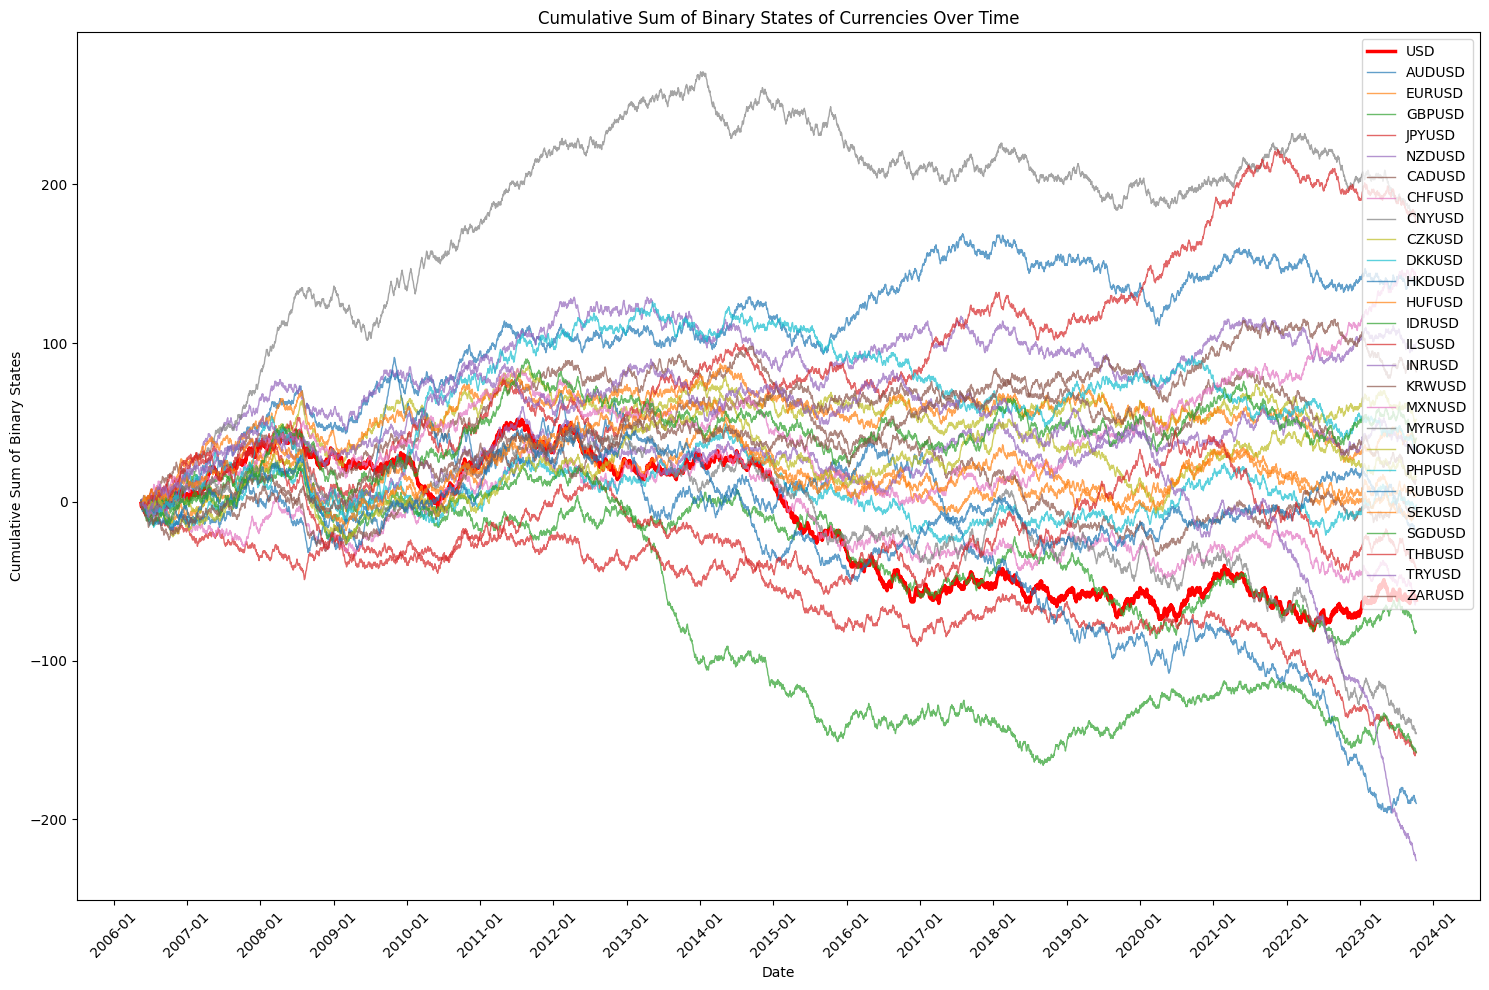

In [3]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define utility functions
def format_date_axis():
    """Formats the date axis with year and month."""
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)

def plot_cumulative_binary_states(data, cumsum_data, title, highlight_currency=None):
    """Plots the cumulative sum of binary states for given currencies."""
    plt.figure(figsize=(15, 10))
    for column in cumsum_data.columns:
        if column == highlight_currency:
            # Highlight the specified currency with a different style
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=2.5, color='red')
        else:
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=1, alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Sum of Binary States')
    plt.title(title)
    format_date_axis()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Read and process data
data_matrix_extended = pd.read_csv("Results/data_matrix_extended.csv")

# Convert the 'Date' column to datetime and sort the data
data_matrix_extended['Date'] = pd.to_datetime(data_matrix_extended['Date'])

# Cumulative sum of binary states
data_matrix_cumsum = data_matrix_extended.drop(columns=['Date']).cumsum()

# Plot with USD highlighted
plot_cumulative_binary_states(data_matrix_extended, data_matrix_cumsum, 
                            'Cumulative Sum of Binary States of Currencies Over Time', 
                            highlight_currency='USD')